In [ ]:
# Case Quantum Finance - Apresentação/Estudo de aplicação em Reinforcement Learning
# Bruno Gomes 358853

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces

In [20]:
# Baixando dados
tickers = ['VALE3.SA', 'PETR4.SA', 'BRFS3.SA']
data = {}
for ticker in tickers:
    print(f"Baixando dados {ticker}")
    df = yf.download(ticker, start='2015-01-01', end='2024-01-01')
    data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Baixando dados VALE3.SA
Baixando dados PETR4.SA
Baixando dados BRFS3.SA


In [21]:
# Ambiente de Trading simples
class TradingEnv(gym.Env):
    def __init__(self, df, window_size=10, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index()
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.current_step = window_size
        self.balance = initial_balance
        self.shares_held = 0
        self.total_asset = initial_balance
        self.action_space = spaces.Discrete(3)  # 0 = vender, 1 = manter, 2 = comprar
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window_size,), dtype=np.float32)

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_asset = self.initial_balance
        return self._get_observation()

    def _get_observation(self):
        return self.df['Close'].values[self.current_step - self.window_size:self.current_step]

    def step(self, action):
        current_price = self.df['Close'].values[self.current_step]
        done = False

        if action == 0:  # vender
            self.balance += current_price * self.shares_held
            self.shares_held = 0
        elif action == 2:  # comprar
            can_buy = self.balance // current_price
            self.balance -= can_buy * current_price
            self.shares_held += can_buy

        self.current_step += 1

        prev_total_asset = self.total_asset
        self.total_asset = self.balance + self.shares_held * current_price

        reward = self.total_asset - prev_total_asset

        if self.current_step >= len(self.df) - 1:
            done = True

        obs = self._get_observation()
        return obs, reward, done, {}

In [22]:
# Agente DQN
class DQNAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, batch_size=64, memory_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def _build_model(self):
        return nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )

    def memorize(self, state, action, reward, next_state, done):
        state = np.array(state).flatten()
        next_state = np.array(next_state).flatten()
        reward = float(reward)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).view(1, -1).to(self.device)
        with torch.no_grad():
            act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        actions = torch.LongTensor(np.array(actions)).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards, dtype=np.float32)).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(np.array(dones, dtype=np.float32)).unsqueeze(1).to(self.device)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.loss_fn(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [23]:
# Preparando ambientes e agentes
window_size = 10
initial_balance = 10000

envs = {}
agents = {}

for ticker in tickers:
    df = data[ticker]
    envs[ticker] = TradingEnv(df, window_size=window_size, initial_balance=initial_balance)
    state_size = window_size
    action_size = envs[ticker].action_space.n
    agents[ticker] = DQNAgent(state_size, action_size)

In [24]:
# Loop de treinamento
num_episodes = 10

for ticker in tickers:
    print(f"\nTreinando agente para {ticker}")
    env = envs[ticker]
    agent = agents[ticker]
    for e in range(num_episodes):
        state = env.reset()
        state = np.array(state).flatten()  # garante vetor 1D
        done = False
        total_reward = 0.0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.array(next_state).flatten()  # garante vetor 1D
            reward = float(reward)  # garante reward float escalar
            agent.memorize(state, action, reward, next_state, done)
            agent.replay()
            state = next_state
            total_reward += reward
        print(f"Episode {e+1}/{num_episodes} - Recompensa total: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


Treinando agente para VALE3.SA


<ipython-input-24-38c126f05b01>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = float(reward)  # garante reward float escalar


Episode 1/10 - Recompensa total: -4735.02, Epsilon: 0.010
Episode 2/10 - Recompensa total: 3076.02, Epsilon: 0.010
Episode 3/10 - Recompensa total: -1626.97, Epsilon: 0.010
Episode 4/10 - Recompensa total: 465.11, Epsilon: 0.010
Episode 5/10 - Recompensa total: -892.37, Epsilon: 0.010
Episode 6/10 - Recompensa total: 6805.43, Epsilon: 0.010
Episode 7/10 - Recompensa total: 3578.32, Epsilon: 0.010
Episode 8/10 - Recompensa total: 10151.42, Epsilon: 0.010
Episode 9/10 - Recompensa total: -3177.35, Epsilon: 0.010
Episode 10/10 - Recompensa total: 2530.48, Epsilon: 0.010

Treinando agente para PETR4.SA
Episode 1/10 - Recompensa total: -5749.98, Epsilon: 0.010
Episode 2/10 - Recompensa total: -87.54, Epsilon: 0.010
Episode 3/10 - Recompensa total: 356.17, Epsilon: 0.010
Episode 4/10 - Recompensa total: 1811.51, Epsilon: 0.010
Episode 5/10 - Recompensa total: 2180.40, Epsilon: 0.010
Episode 6/10 - Recompensa total: 26585.21, Epsilon: 0.010
Episode 7/10 - Recompensa total: 95901.09, Epsilon: 

<ipython-input-25-42dc167b6f19>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = float(reward)


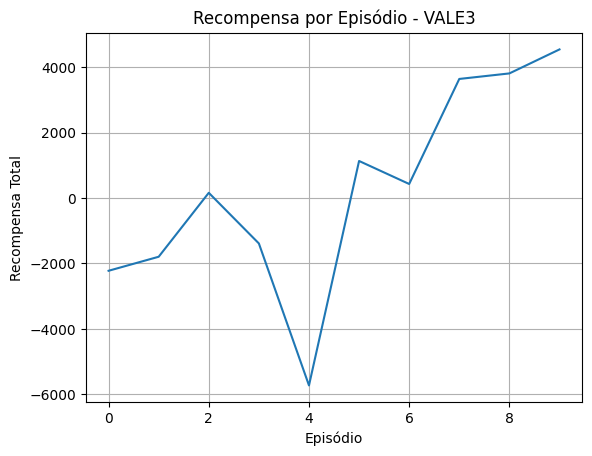

In [25]:
import matplotlib.pyplot as plt

# Exemplo para VALE3
rewards_log = []

for e in range(num_episodes):
    state = env.reset()
    state = np.array(state).flatten()
    done = False
    total_reward = 0.0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array(next_state).flatten()
        reward = float(reward)
        agent.memorize(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
    rewards_log.append(total_reward)

# Plot
plt.plot(rewards_log)
plt.title("Recompensa por Episódio - VALE3")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")
plt.grid(True)
plt.show()

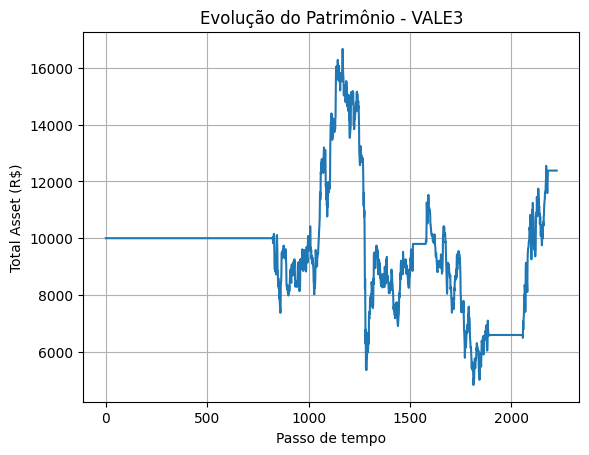

In [26]:
# Avaliação do agente
state = env.reset()
state = np.array(state).flatten()
done = False
total_asset_log = []

while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.array(next_state).flatten()
    state = next_state
    total_asset_log.append(env.total_asset)

# Plot
plt.plot(total_asset_log)
plt.title("Evolução do Patrimônio - VALE3")
plt.xlabel("Passo de tempo")
plt.ylabel("Total Asset (R$)")
plt.grid(True)
plt.show()

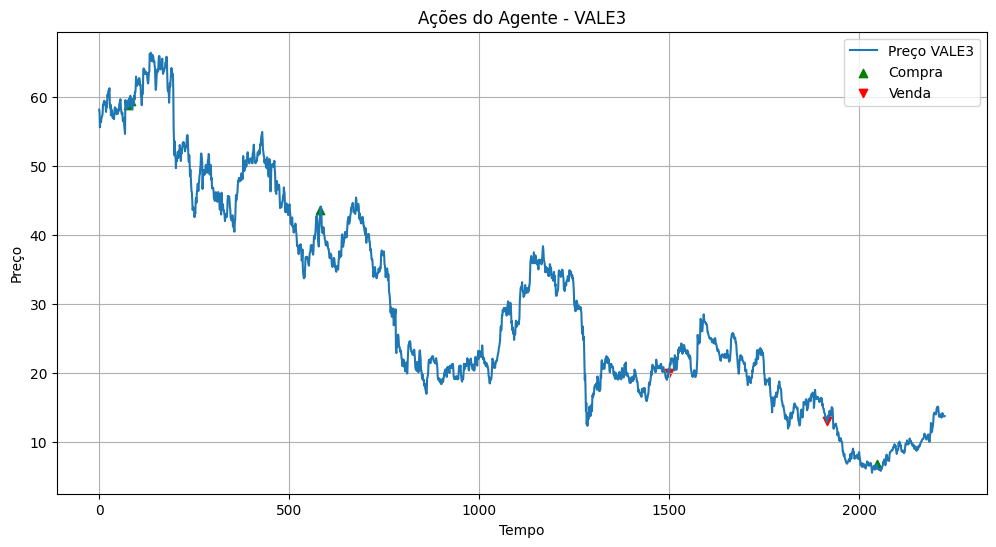

In [27]:
state = env.reset()
state = np.array(state).flatten()
done = False
prices = env.df['Close'].values[window_size:]
actions = []

while not done:
    action = agent.act(state)
    actions.append(action)
    next_state, reward, done, _ = env.step(action)
    next_state = np.array(next_state).flatten()
    state = next_state

# Plot com ações
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Preço VALE3')

buy_signals = [i for i, a in enumerate(actions) if a == 2]
sell_signals = [i for i, a in enumerate(actions) if a == 0]

plt.scatter(buy_signals, prices[buy_signals], marker='^', color='green', label='Compra')
plt.scatter(sell_signals, prices[sell_signals], marker='v', color='red', label='Venda')

plt.title("Ações do Agente - VALE3")
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.legend()
plt.grid(True)
plt.show()